<a href="https://colab.research.google.com/github/fralfaro/aves/blob/master/docs/notebooks/vis-course/03-python-mapas-preliminario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unidad Práctica 3: Preparación de Datos de GeoPandas

En este notebook trabajaremos con información geográfica. Generaremos información preliminar para la unidad práctica de mapas. Vamos a cargar y procesar datos geográficos en formato _shapefile_, con la biblioteca `geopandas`. Esto incluye cruzar y operar con archivos desde distintas fuentes y en distintos sistemas de coordenadas.

## Preámbulo y Carga de Datos

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 96
# esto depende de las fuentes que tengas instaladas en el sistema.
mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"

# Importar la biblioteca seaborn para la visualización de datos
import seaborn as sns

# Establecer el estilo de fondo de las gráficas como "whitegrid" en seaborn.
sns.set_style("whitegrid")

Para datos geográficos trabajaremos con el formato `shapefile`. Se define así:

> El formato ESRI Shapefile (SHP) es un formato de archivo informático propietario de datos espaciales desarrollado por la compañía ESRI, quien crea y comercializa software para Sistemas de Información Geográfica como Arc/Info o ArcGIS. Originalmente se creó para la utilización con su producto ArcView GIS, pero actualmente se ha convertido en formato estándar de facto para el intercambio de información geográfica entre Sistemas de Información Geográfica por la importancia que los productos ESRI tienen en el mercado SIG y por estar muy bien documentado.
>
> Un shapefile es un formato vectorial de almacenamiento digital donde se guarda la localización de los elementos geográficos y los atributos asociados a ellos. No obstante carece de capacidad para almacenar información topológica. Es un formato multiarchivo, es decir está generado por varios ficheros informáticos. 
>
> -- [Wikipedia](https://es.wikipedia.org/wiki/Shapefile)

En general, los archivos `.shp` se almacenan en una carpeta donde otros archivos complementarios a la geografía tienen el mismo nombre pero con extensiones diferentes, por ejemplo, para almacenar meta-datos de la geografía.

La encuesta origen-destino disponibiliza un `shapefile` de las zonas de estudio en la [biblioteca](http://www.sectra.gob.cl/encuestas_movilidad/encuestas_movilidad.htm) de la SECTRA (Secretaría de Transporte). Sin embargo, el link está escondido en el código fuente de la página, ya que presenta problemas de rendering. Afortunadamente ya está en el repositorio del curso :)

Cargamos el fichero con el método `read_zone_design` de aves:

In [2]:
# leer Zonificacion_EOD2012

path = "https://raw.githubusercontent.com/zorzalerrante/aves/master/data/external/Zonificacion_EOD2012/Zonificacion_EOD2012.shp"
zonas_eod = gpd.read_file(path)
zonas_eod.head()

,ID,AREA,Zona,Com,Comuna,geometry
0,103,837.7500,103.0,13105,El Bosque,"POLYGON ((346376.693 6286027.029, 346366.556 6..."
1,104,998.8125,104.0,13105,El Bosque,"POLYGON ((344151.235 6285465.040, 344263.705 6..."
2,106,286.2500,106.0,13105,El Bosque,"POLYGON ((344415.434 6285878.048, 344263.705 6..."
3,115,857.4375,115.0,13105,El Bosque,"POLYGON ((344415.434 6285878.048, 344412.704 6..."
4,116,853.9375,116.0,13105,El Bosque,"POLYGON ((345133.421 6286261.983, 345243.965 6..."


Como ven, su apariencia es la de un `DataFrame`. Sin embargo, la columna `geometry` tiene un significado especial: contiene los elementos geográficos.

Adicionalmente, un `GeoDataFrame` tiene un método `plot` que se encarga de graficar los contenidos geográficos:

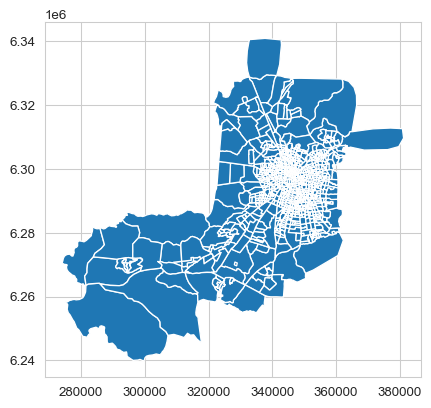

In [3]:
zonas_eod.plot()
plt.show()

El sistema de coordenadas utilizado por este fichero se puede ver con el atributo `crs` del `GeoDataFrame`:

In [4]:
zonas_eod.crs

<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Chile. Colombia. Peru.
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Las zonas utilizan el sistema de coordenadas [`EPSG:32719`](https://epsg.io/32719). Más adelante veremos que los archivos pueden tener sistemas de coordenadas distintos, pero que `geopandas` nos ayuda a trabajar con ello, permitiendo convertir datos de un sistema a otro.

A veces solo sabemos que queremos visualizar un área, pero no tenemos sus bordes ni un shapefile que defina lo que usamos como "área urbana".

En tal caso, uno puede acudir a servicios como [bbox finder](http://bboxfinder.com/#-33.764791,-70.995712,-33.171462,-70.445023) donde se puede dibujar un área de interés. _bbox_ es la abreviación de _Bounding Box_, o caja contenedora, es decir, el rectángulo que contiene el área que nos interesa visualizar.

La caja que hemos dibujado utilizando el sitio está almacenada en la variable `bbox`. La hemos copiado y pegado desde la página. Luego utilizaremos el método `clip_area_geodataframe` de aves para quedarnos con las zonas que estén en nuestra área de interés.

Noten que debemos convertir las zonas al sistema de coordenadas propio de la caja `bbox`, ya que utiliza latitud/longitud.

C:\Users\franc\AppData\Local\Temp\ipykernel_26672\3823514132.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  result = geodf[geodf.geometry.intersects(bounds) & (geodf.geometry.area > 0)]


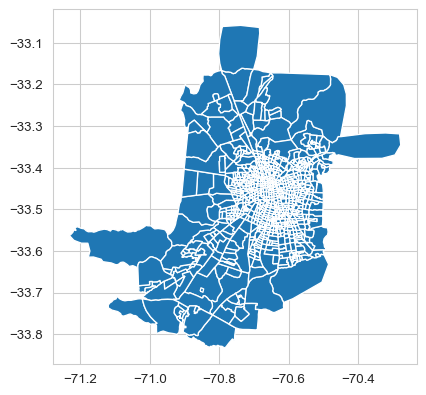

In [5]:
from shapely.geometry import box

def clip_area_geodataframe(geodf, bounding_box, buffer=0):
    # Crear una geometría de bounding box en la misma proyección que el GeoDataFrame
    bounds = box(*bounding_box).buffer(buffer)

    try:
        # Realizar la intersección y filtrar las geometrías con área positiva
        result = geodf[geodf.geometry.intersects(bounds) & (geodf.geometry.area > 0)]
    except Exception:
        # En caso de errores, aplicar un buffer a las geometrías del GeoDataFrame antes de la intersección
        result = geodf[geodf.geometry.buffer(0).intersects(bounds) & (geodf.geometry.area > 0)]

    return result

bbox = [-70.995712,-33.764791,-70.445023,-33.171462]

zonas_en_caja = clip_area_geodataframe(zonas_eod.to_crs('epsg:4326'), bbox)
zonas_en_caja.plot()
plt.show()

Estas cajas nos permiten hacer varias cosas. Una de ellas es acceder a servicios Web que proveen imágenes de fondo para mapas. La biblioteca contextily nos permite acceder a ellas. Ahora bien, en general esas bibliotecas trabajan con el sistema de coordenadas Web Mercator, así que debemos convertir la caja contenedora de nuestro shapefile a ese formato. Lo hacemos convirtiendo los datos al sistema nuevo, y luego calculando su caja contenedora con el atributo `total_bounds`:

In [6]:
bounds = zonas_en_caja.to_crs('EPSG:3857').total_bounds
bounds

array([-7929507.40783916, -4006428.2651953 , -7823206.75628737,
       -3902992.27543615])

In [7]:
import contextily as cx

scl_img, scl_ext = cx.bounds2raster(bounds[0], bounds[1], bounds[2], bounds[3], 
    "data/scl_toner_12.tif",
    ll=False,
    source=cx.providers.Stamen.TonerBackground,
    zoom=12,
)

> **Nota**: Debes tener descargado el archivo [scl_toner_12.tif](https://github.com/zorzalerrante/aves/blob/master/data/processed/scl_toner_12.tif) en tu computador local o google colab.

Así luce la imagen que hemos descargado:

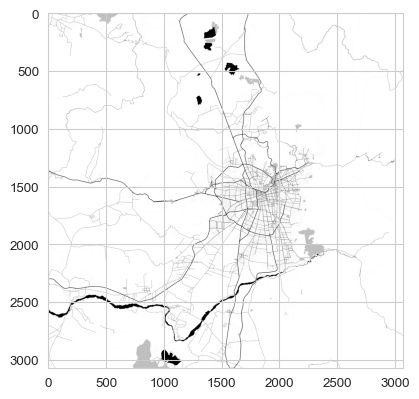

In [8]:
plt.imshow(scl_img)
plt.show()

La imagen quedó almacenada en `AVES_ROOT / "data" / "processed" / "scl_toner_12.tif"`. Como vemos, contiene información territorial. Observamos que no todas las zonas que componen nuestros datos son zonas urbanas. Si quisiéramos dedicarnos al análisis urbano, ¿cómo podemos identificar las áreas urbanas y las rurales? Para ello podemos utilizar datos del Censo 2017.

El Censo 2017 disponibiliza una serie de `shapefiles` para cada región del país. En este caso, cargaremos un mapa para la Región Metropolitana (en la carpeta `R13`, que está incluida en el repositorio) con los límites urbanos definidos por el INE. Noten que en este caso le indicamos el nombre del archivo `.shp` a `geopandas`, debido a que la carpeta tiene otros ficheros `.shp`.

In [9]:
path = "https://raw.githubusercontent.com/zorzalerrante/aves/master/data/external/censo_2017_R13/LIMITE_URBANO_CENSAL_C17.shp"
rm = gpd.read_file(path)
rm.head()

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PAINE,CAPITAL COMUNAL,CIUDAD,0.146714,0.000531,"POLYGON ((-70.73797 -33.79851, -70.73738 -33.7..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,HUELQUÉN,URBANO,PUEBLO,0.167916,0.000205,"POLYGON ((-70.64840 -33.81521, -70.64859 -33.8..."
2,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,HOSPITAL,URBANO,CIUDAD,0.139694,0.000445,"POLYGON ((-70.76468 -33.84349, -70.76448 -33.8..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PINTUÉ - LA GUACHERA,URBANO,PUEBLO,0.148207,0.000292,"POLYGON ((-70.87824 -33.86540, -70.87839 -33.8..."
4,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,EL TRÁNSITO,URBANO,PUEBLO,0.073625,0.000066,"POLYGON ((-70.65834 -33.78357, -70.65832 -33.7..."


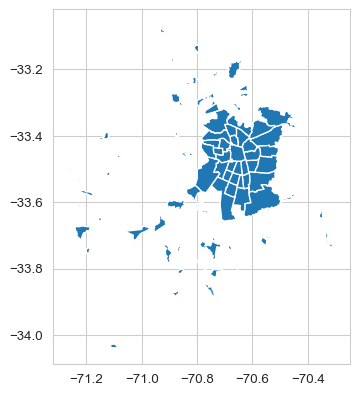

In [10]:
rm.plot()
plt.show()

Notamos que las áreas urbanas están separadas por comuna. El siguiente paso es ver como podemos intersectar las zonas EOD que tenemos con estas áreas urbanas, de modo que las zonas que estén en los bordes urbanos se recorten y queden solamente con la sección urbana que les corresponda.

Para ello podemos usar la operación `overlay` de `geopandas`. Este método recibe dos `GeoDataFrame` y un nombre de operación. En este caso, diremos que queremos _intersectar_ con `zonas_en_caja` y `rm`.

Antes de realizar la intersección, las convertimos al mismo sistema de coordenadas:

<Axes: >

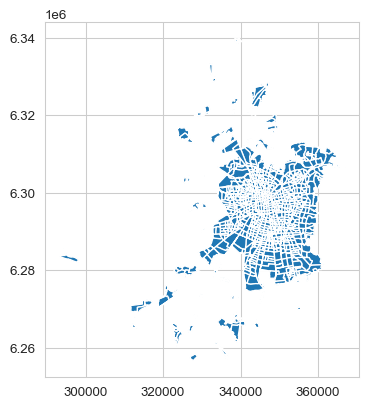

In [11]:
zonas_urbanas = gpd.overlay(zonas_en_caja.to_crs(zonas_eod.crs), rm.to_crs(zonas_eod.crs), how='intersection')
zonas_urbanas.plot()

Como resultado tenemos las zonas EOD considerando solamente las áreas urbanas definidas en el censo dentro de las coordenadas que nos interesan (de acuerdo a la caja contenedora que definimos manualmente).

Lo siguiente que haremos será calcular el área en metros cuadrados de cada una de las zonas. A veces las operaciones de intersección dejan artefactos (zonas con áreas nulas o muy pequeñas). Utilizaremos el cálculo para descartar esas áreas. El atributo `area` es un `GeoDataFrame` hace el cálculo:

In [12]:
zonas_urbanas['area_m2'] = zonas_urbanas.area

Saquemos las áreas pequeñas que tengan un área menor a 10 hectáreas (umbral decidido manualmente):

In [13]:
zonas_urbanas = zonas_urbanas[zonas_urbanas['area_m2'] > 100000]


Así quedó el `GeoDataFrame` final:

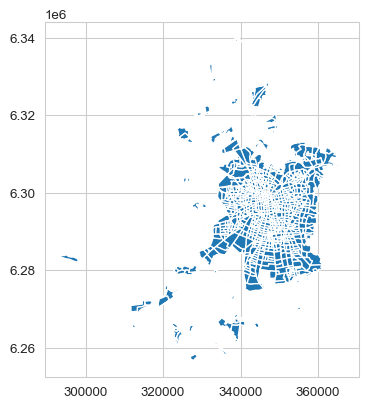

In [14]:
zonas_urbanas.plot()
plt.show()

In [15]:
zonas_urbanas.head()

,ID,AREA,Zona,Com,Comuna,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,geometry,area_m2
0,103,837.7500,103.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,"POLYGON ((346366.556 6285963.977, 346371.218 6...",4.575649e+05
1,104,998.8125,104.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,"POLYGON ((344263.705 6285642.000, 344415.434 6...",7.725462e+05
2,106,286.2500,106.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,"POLYGON ((344263.705 6285642.000, 344151.235 6...",2.693838e+06
3,115,857.4375,115.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,"POLYGON ((344412.704 6285897.526, 344391.421 6...",7.534193e+05
4,116,853.9375,116.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,"POLYGON ((345243.965 6286237.030, 345371.399 6...",7.184305e+05


En este punto, ya tenemos dos elementos que podemos utilizar para trabajar con viajes en el área urbana de Santiago.

Guardaremos el archivo en formato GeoJSON. Usualmente este formato se utiliza con coordenadas latitud/longitud, así que convertimos al sistema correspondiente:

```python
zonas_urbanas.to_crs("epsg:4326").to_file("scl_zonas_urbanas.json", driver='GeoJSON')
```

> Ver ejemplo de este archivo en [scl_zonas_urbanas.json](https://github.com/zorzalerrante/aves/blob/master/data/processed/scl_zonas_urbanas.json)